<img align="left" width="220px" height="220px" src="https://astra.dk/sites/default/files/DTU%20logo.png" alt="logo"/>
<div>
    <h1 style="text-align: right"> Stochastic Simulation</h1>
    <h3 style="text-align: right"> Brian Tang (s192389), Reda Lahlou (s192431), Vlad Tampiza (s200384)</h3>
</div>

# <span style="color:#BA2121"> Simulation of Solar energy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import choice, sample

from collections import Counter
import datetime

sns.set(rc={'figure.figsize':(6, 4)})
myColor = '#BA2121'

### <span style="color:#008000"> Table of content:
* [I Data preparation](#first-part)
* [II Resample activities](#second-part)
* [III Transition matrix](#third-part)
* [IV Activity generation](#fourth-part)
* [V Exporting a first baseline simulation](#fifth-part)
* [VI Simulating activities for different categories](#sixth-part)
* [VII Categorization and validation](#seventh-part)

## <span style="color:#990000"> I - Data preparation <a class="anchor" id="first-part"></a>

### 1. activity_short.csv

In [2]:
df_activity_short = pd.read_csv('activity_short.csv')
print(len(df_activity_short))
df_activity_short.head(2)

500


,serial,pnum,t_start,eptime,whatdoing_exact,WhereWhen,whatdoing
0,11011202,1,2014-12-11T03:00:00Z,110,110,11,0
1,11011202,1,2014-12-11T04:50:00Z,10,8219,11,8


> activity_short.csv is only the 500 first rows of activity.csv. Therefore, we will directly use activity.csv

### 2. activity.csv

In [3]:
df_activity = pd.read_csv('activity.csv')

#drop NA
df_activity.dropna(inplace=True)

#convert to datetime format
df_activity['t_start'] = pd.to_datetime(df_activity['t_start'])

print(len(df_activity))
df_activity.head()

585569


,serial,pnum,t_start,eptime,whatdoing_exact,WhereWhen,whatdoing
0,11011202,1,2014-12-11 03:00:00+00:00,110,110,11,0
1,11011202,1,2014-12-11 04:50:00+00:00,10,8219,11,8
2,11011202,1,2014-12-11 05:00:00+00:00,10,310,11,0
3,11011202,1,2014-12-11 05:10:00+00:00,10,3210,11,3
4,11011202,1,2014-12-11 05:20:00+00:00,10,3110,11,3


In [4]:
records_count = df_activity['serial'].value_counts()
records_count

18020220    672
21070717    590
18080918    578
15230217    553
15241115    527
           ... 
11220908     16
18241103     13
31080615     11
15070708     11
15070706      9
Name: serial, Length: 4229, dtype: int64

> For some households, there are more than 500 records whereas for others there are only 10 records. Therefore, we will only consider households who more than 400 records.

In [5]:
df_activity = df_activity[df_activity.serial.isin(records_count[records_count>400].index)]
print(len(df_activity))
df_activity.head()

20079


,serial,pnum,t_start,eptime,whatdoing_exact,WhereWhen,whatdoing
12864,11070419,1,2014-04-19 02:00:00+00:00,190,110,11,0
12865,11070419,1,2014-04-19 05:10:00+00:00,20,310,11,0
12866,11070419,1,2014-04-19 05:30:00+00:00,10,210,11,0
12867,11070419,1,2014-04-19 05:40:00+00:00,10,210,11,0
12868,11070419,1,2014-04-19 05:50:00+00:00,10,210,11,0


In [6]:
#add a column to distinguish individuals within a household
df_activity['individual'] = df_activity['serial'].astype(str) +'-'+ df_activity['pnum'].astype(str)
df_activity.head()

,serial,pnum,t_start,eptime,whatdoing_exact,WhereWhen,whatdoing,individual
12864,11070419,1,2014-04-19 02:00:00+00:00,190,110,11,0,11070419-1
12865,11070419,1,2014-04-19 05:10:00+00:00,20,310,11,0,11070419-1
12866,11070419,1,2014-04-19 05:30:00+00:00,10,210,11,0,11070419-1
12867,11070419,1,2014-04-19 05:40:00+00:00,10,210,11,0,11070419-1
12868,11070419,1,2014-04-19 05:50:00+00:00,10,210,11,0,11070419-1


In [7]:
#Consider only relevant features
df_activity2 = df_activity[['individual','t_start','eptime','whatdoing']]

### 3. households.csv

In [8]:
df_household = pd.read_csv('household.csv')
print(len(df_household))
df_household.head()

4733


,serial,num_adult,num_child,num_room,microwav,dishwash,dhhtype
0,11010903,2,0,8,True,True,3.0
1,11010904,2,0,6,False,True,3.0
2,11010906,3,0,4,True,False,7.0
3,11010907,2,1,3,True,False,2.0
4,11010908,1,0,6,True,True,1.0


### 4. individuals.csv

In [9]:
df_individual = pd.read_csv('individual.csv')
print(len(df_individual),"individuals")
df_individual.head()

11421 individuals


,serial,pnum,sex,age,deconact
0,11010903,1,1,80,7.0
1,11010903,2,2,71,7.0
2,11010904,1,2,55,2.0
3,11010904,2,1,62,1.0
4,11010906,1,2,52,2.0


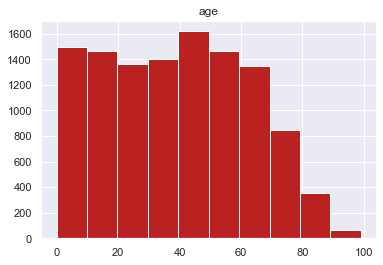

In [10]:
df_individual.hist(column='age', color=myColor);

## <span style="color:#990000"> II - Resample activities <a class="anchor" id="second-part"></a>
In the following, we will only focus on `df_activity`

### 1. Time resample
We aim at filling all "10 minutes time slots" for everyone. Currently, some times slots are not directly filled in. They are implicited by `eptime`

In [11]:
dict_activity = {}
i=0

for index, row in df_activity2.iterrows():
    for j in range(int(row['eptime']/10-1)):
        dict_activity[i] = {'individual':row['individual'],
                            't_start':row['t_start'] + datetime.timedelta(minutes=10*(j+1)),
                            'eptime':10,
                            'whatdoing':row['whatdoing']}
        i+=1

In [12]:
#Cocnat our main dataframe and the dict previously created
df_activity2 = pd.concat([df_activity2,pd.DataFrame.from_dict(dict_activity, "index")], ignore_index=True)

#no need of the eptime column anymore
del df_activity2['eptime']

print(len(df_activity2))
df_activity2.head()

62811


,individual,t_start,whatdoing
0,11070419-1,2014-04-19 02:00:00+00:00,0
1,11070419-1,2014-04-19 05:10:00+00:00,0
2,11070419-1,2014-04-19 05:30:00+00:00,0
3,11070419-1,2014-04-19 05:40:00+00:00,0
4,11070419-1,2014-04-19 05:50:00+00:00,0


In [13]:
#Sort by individual and then t_start
df_activity2.sort_values(by=['individual','t_start'], inplace=True)
df_activity2.head(10)

,individual,t_start,whatdoing
50,11070419-1,2014-04-18 22:00:00+00:00,0
20149,11070419-1,2014-04-18 22:10:00+00:00,0
20150,11070419-1,2014-04-18 22:20:00+00:00,0
20151,11070419-1,2014-04-18 22:30:00+00:00,0
20152,11070419-1,2014-04-18 22:40:00+00:00,0
20153,11070419-1,2014-04-18 22:50:00+00:00,0
20154,11070419-1,2014-04-18 23:00:00+00:00,0
20155,11070419-1,2014-04-18 23:10:00+00:00,0
20156,11070419-1,2014-04-18 23:20:00+00:00,0
20157,11070419-1,2014-04-18 23:30:00+00:00,0


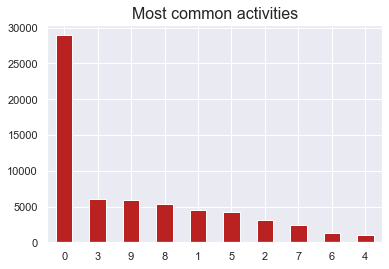

In [14]:
df_activity2['whatdoing'].value_counts().sort_values(ascending=False).plot(
    kind='bar', rot=0,
    color=myColor)
plt.title('Most common activities', fontsize=16);

### 2. Focus on an individual 
We closer investigate one single individual and its activities.

In [15]:
df_top_individual = df_activity2[df_activity2.individual=='18020220-1']
df_top_individual.head()

,individual,t_start,whatdoing
15183,18020220-1,2015-03-01 23:40:00+00:00,9
52643,18020220-1,2015-03-01 23:50:00+00:00,9
52644,18020220-1,2015-03-02 00:00:00+00:00,9
52645,18020220-1,2015-03-02 00:10:00+00:00,9
52646,18020220-1,2015-03-02 00:20:00+00:00,9


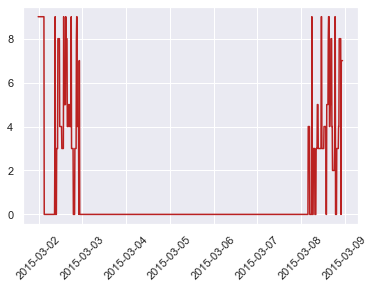

In [16]:
plt.plot(df_top_individual['t_start'],df_top_individual['whatdoing'], color=myColor)
plt.xticks(rotation=45)
plt.show()

141


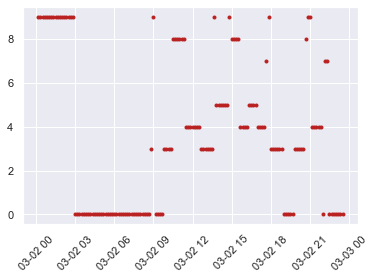

In [17]:
#plot with data of a single day (03-02)
df2 = df_top_individual[(df_top_individual.t_start>'2015-03-02') & (df_top_individual.t_start<'2015-03-03')]
print(len(df2))
plt.plot(df2['t_start'],df2['whatdoing'], '.', color=myColor)
plt.xticks(rotation=45)
plt.show()

**Our goal is to resample this activity dataset to have only one acivity per hour. We'll randomly choose an activity for each time slots.**

In [18]:
i=0
global_series_activity=[]

while i<len(df2)-1:
    currentHour=df2.t_start.iloc[i].hour
    temp_activities=[]
    temp_activities.append(df2.whatdoing.iloc[i])
    
    while i<len(df2)-1 and df2.t_start.iloc[i+1].hour == currentHour:
        i+=1
        temp_activities.append(df2.whatdoing.iloc[i])
        
    #random choice for the activity
    activity = choice(temp_activities)
    
    #we store this choice in a global list
    global_series_activity.append(activity)
    
    i+=1
    
global_series_activity

[9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 3, 4, 3, 3, 5, 4, 5, 9, 3, 0, 3, 4, 0, 0]

In [19]:
df3 = df2
df3.set_index('t_start', inplace=True)

In [20]:
df3 = df3.resample('H').count()
df3['whatdoing']=global_series_activity
df3.head()

,individual,whatdoing
t_start,,
2015-03-02 00:00:00+00:00,5,9
2015-03-02 01:00:00+00:00,6,9
2015-03-02 02:00:00+00:00,6,9
2015-03-02 03:00:00+00:00,6,0
2015-03-02 04:00:00+00:00,6,0


### 3. Global resample
And now let's apply this process to the whole dataset. The resample method does not work when it is appleid to the whole dataset. Therefore, we have to build a new dataframe manually.

In [21]:
#create empty dataframe
df_activity3 = pd.DataFrame(columns=['individual', 't_start', 'whatdoing'])

#first loop through each individuals
for individual in df_activity2.individual.unique():
    df_temp=df_activity2[df_activity2.individual==individual][['individual', 't_start', 'whatdoing']]
    
    #second loop through time
    i=0
    while i<len(df_temp)-1:
        currentHour=df_temp.t_start.iloc[i].hour
        temp_activities=[]
        temp_activities.append(df_temp.whatdoing.iloc[i])

        while i<len(df_temp)-1 and df_temp.t_start.iloc[i+1].hour == currentHour:
            i+=1
            temp_activities.append(df_temp.whatdoing.iloc[i])

        #random choice for the activity
        activity = choice(temp_activities)
        
        #append a new row to the created dataframe
        df_activity3 = df_activity3.append({'individual':individual,
                                            't_start':df_temp.t_start.iloc[i].replace(minute=0), #hour
                                            'whatdoing':activity}, ignore_index=True)

        i+=1
        
df_activity3

,individual,t_start,whatdoing
0,11070419-1,2014-04-18 22:00:00+00:00,0
1,11070419-1,2014-04-18 23:00:00+00:00,0
2,11070419-1,2014-04-19 00:00:00+00:00,0
3,11070419-1,2014-04-19 01:00:00+00:00,0
4,11070419-1,2014-04-19 02:00:00+00:00,0
...,...,...,...
10491,32051017-6,2015-10-21 21:00:00+00:00,0
10492,32051017-6,2015-10-21 22:00:00+00:00,0
10493,32051017-6,2015-10-21 23:00:00+00:00,0
10494,32051017-6,2015-10-22 00:00:00+00:00,0


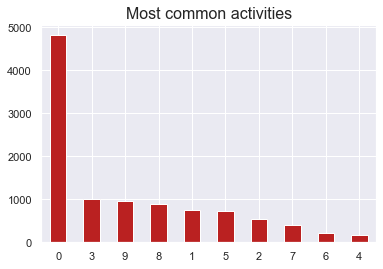

In [22]:
df_activity3['whatdoing'].value_counts().sort_values(ascending=False).plot(
    kind='bar', rot=0,
    color=myColor)
plt.title('Most common activities', fontsize=16);

**REMARK BY REDA** 
The data does not cover a single year, but it is spanned across 2014 and 2015.

In [23]:
dates = pd.to_datetime(df_activity3["t_start"])
print("From: ",min([dates[i].date() for i in range(len(dates))]), " to: ", max([dates[i].date() for i in range(len(dates))]))

From:  2014-04-18  to:  2015-12-01


Plus, there is not the same number of observations in each month. For example, we do not have any observation for the first half of April.

In [24]:
df_activity4 = df_activity3
df_activity4["t_start"] = pd.to_datetime(df_activity4["t_start"])
df_activity4["year"] = df_activity4["t_start"].dt.year
df_activity4["month"] = df_activity4["t_start"].dt.month

counts = df_activity4.groupby(["year","month"]).agg("count")
counts

individual  t_start  whatdoing
year month                                
2014 4             240      240        240
     5             580      580        580
     6            1143     1143       1143
     7             501      501        501
     8             661      661        661
     9            1203     1203       1203
     10            902      902        902
     11            569      569        569
     12            335      335        335
2015 1             805      805        805
     2             683      683        683
     3            2202     2202       2202
     6             190      190        190
     10            289      289        289
     11            169      169        169
     12             24       24         24

## <span style="color:#990000"> III - Transition matrix <a class="anchor" id="third-part"></a>
Let's build the transition probabilities matrix for activities. The matrix is going to be a 10 X 10 matrix since there is 10 activities. Rows represent the current activity. Columns represent the next activity.

In [25]:
def transition(df, verbose=True):
    #returns list of 24 transition matrices for each hour
    #df must have a column called "hour"
    list_P = []
    rows_with_only_zeros = 0
    
    for h in range(24):
        transition_matrix = np.zeros((10, 10))
        df_hour = df[df.hour==h]
        #first loop through each individuals
        for individual in df_hour.individual.unique():
            df_temp=df_hour[df_hour.individual==individual]
            #second loop through activity
            for i in range(len(df_temp)-1):
                act_from = df_temp['whatdoing'].iloc[i]
                act_to = df_temp['whatdoing'].iloc[i+1]
                transition_matrix[act_from, act_to]+=1  
                
        #normalization
        for i in range(transition_matrix.shape[0]):
            summ=np.sum(transition_matrix[i])
            for j in range(transition_matrix.shape[1]):
                transition_matrix[i,j]=transition_matrix[i,j]/summ
        #replace rows of nans by row of 0.1
        rows_with_only_zeros+=int(np.sum(pd.isnull(transition_matrix))/10)
        transition_matrix[pd.isnull(transition_matrix)]=0.1
        
        list_P.append(transition_matrix)
        
    if verbose:
        print("No. of rows with only zeros:", rows_with_only_zeros)
        
    return list_P

In [26]:
df_activity4["hour"] = df_activity4["t_start"].dt.hour
df_activity4.head()

,individual,t_start,whatdoing,year,month,hour
0,11070419-1,2014-04-18 22:00:00+00:00,0,2014,4,22
1,11070419-1,2014-04-18 23:00:00+00:00,0,2014,4,23
2,11070419-1,2014-04-19 00:00:00+00:00,0,2014,4,0
3,11070419-1,2014-04-19 01:00:00+00:00,0,2014,4,1
4,11070419-1,2014-04-19 02:00:00+00:00,0,2014,4,2


In [27]:
list_P = transition(df_activity4)

#pretty-print numpy array
np.set_printoptions(precision=2, suppress=True)
print(list_P)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


No. of rows with only zeros: 31
[array([[0.96, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.02, 0.01],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ]]), array([[0.98, 0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01],
       [0.25, 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],

## <span style="color:#990000"> IV - Activity generation <a class="anchor" id="fourth-part"></a>

We will build a Markov chain from the probailities matrices defined above

In [28]:
def act_gen(list_P,df):
    #generate a list of activity from transition matrices P(hour) corresponding to hours given in the dataframe df
    #df must have an attribute "hour"
    list_act = [0]
    for i in range(len(df)-1):
        h = np.int(df.hour[i])
        P = list_P[h]
        ac_current = list_act[i]
        p = P[ac_current,] #prob to go from current activity to the other ones
        ac_next = np.random.choice(10,1,p=p)[0] #drawn from 9 point distribution with probabilities p
        list_act.append(ac_next)
    return(list_act)

In [29]:
act_list = act_gen(list_P,df_activity4)

In [30]:
act_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 3,
 9,
 3,
 8,
 8,
 1,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 9,
 0,
 1,
 0,
 3,
 1,
 9,
 5,
 4,
 7,
 8,
 5,
 0,
 9,
 0,
 9,
 0,
 0,
 0,
 0,
 8,
 8,
 1,
 8,
 9,
 3,
 5,
 2,
 3,
 5,
 9,
 5,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 9,
 3,
 0,
 7,
 6,
 1,
 1,
 4,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 7,
 1,
 1,
 3,
 1,
 1,
 9,
 9,
 0,
 0,
 7,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 7,
 9,
 0,
 8,
 8,
 7,
 8,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 2,
 2,
 7,
 5,
 1,
 8,
 8,
 5,
 9,
 3,
 3,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 5,
 0,
 9,
 2,
 2,
 3,
 8,
 2,
 7,
 9,
 8,
 8,
 8,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 4,
 1,
 3,
 2,
 0,
 8,
 1,
 9,
 8,
 0,
 5,
 5,
 5,
 0,
 7,
 9,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 1,
 8,
 0,
 9,
 5,
 9,
 0,
 3,
 1,
 1,
 6,
 3,
 0,
 0,
 5,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


## <span style="color:#990000"> V - Exporting a first baseline simulation <a class="anchor" id="fifth-part"></a>

**It is the same transition matrices for everyone and every season**

In [31]:
df_simul = pd.date_range(start="2015-01-01 01:00", end="2016-01-01", freq="H")
df_simul

DatetimeIndex(['2015-01-01 01:00:00', '2015-01-01 02:00:00',
               '2015-01-01 03:00:00', '2015-01-01 04:00:00',
               '2015-01-01 05:00:00', '2015-01-01 06:00:00',
               '2015-01-01 07:00:00', '2015-01-01 08:00:00',
               '2015-01-01 09:00:00', '2015-01-01 10:00:00',
               ...
               '2015-12-31 15:00:00', '2015-12-31 16:00:00',
               '2015-12-31 17:00:00', '2015-12-31 18:00:00',
               '2015-12-31 19:00:00', '2015-12-31 20:00:00',
               '2015-12-31 21:00:00', '2015-12-31 22:00:00',
               '2015-12-31 23:00:00', '2016-01-01 00:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [34]:
with pd.ExcelWriter('Normal_activity.xlsx') as writer:  
    for k in range(2):    
        list_P = transition(df_activity4)
        act_list = pd.DataFrame(act_gen(list_P,df_simul))
        act_list.to_excel(writer,sheet_name=str(k+1),header=False,index=False)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


No. of rows with only zeros: 31
No. of rows with only zeros: 31


## <span style="color:#990000"> VI - Simulating activities for different categories <a class="anchor" id="sixth-part"></a>
**We want to distinguish activities done by a male adult, a female adult and a child. And we want to split the activity simulator into seasons**

### VI.1 Quick data preparation

In [35]:
# we have previously deleted the column serial but we need it to merge
df_activity4['serial']=df_activity4['individual'].apply(lambda x:x[:-2])

print(len(df_activity4))
df_activity4.head(2)

10496


,individual,t_start,whatdoing,year,month,hour,serial
0,11070419-1,2014-04-18 22:00:00+00:00,0,2014,4,22,11070419
1,11070419-1,2014-04-18 23:00:00+00:00,0,2014,4,23,11070419


In [36]:
#convert serial in string format
df_household['serial'] = df_household['serial'].astype(str)

df_household.head(2)

,serial,num_adult,num_child,num_room,microwav,dishwash,dhhtype
0,11010903,2,0,8,True,True,3.0
1,11010904,2,0,6,False,True,3.0


In [37]:
# create a  new column individual
df_individual['individual'] = df_individual['serial'].astype(str) +'-'+ df_individual['pnum'].astype(str)

df_individual.head(2)

,serial,pnum,sex,age,deconact,individual
0,11010903,1,1,80,7.0,11010903-1
1,11010903,2,2,71,7.0,11010903-2


In [38]:
#merge the 3 datasets
df_merged = pd.merge(df_activity4, df_household[['serial', 'num_adult', 'num_child']],how='left', on='serial')

df_merged = pd.merge(df_merged, df_individual[['individual', 'sex', 'age']],how='left', on='individual')

In [39]:
df_merged.head()

,individual,t_start,whatdoing,year,month,hour,serial,num_adult,num_child,sex,age
0,11070419-1,2014-04-18 22:00:00+00:00,0,2014,4,22,11070419,3,2,1,42
1,11070419-1,2014-04-18 23:00:00+00:00,0,2014,4,23,11070419,3,2,1,42
2,11070419-1,2014-04-19 00:00:00+00:00,0,2014,4,0,11070419,3,2,1,42
3,11070419-1,2014-04-19 01:00:00+00:00,0,2014,4,1,11070419,3,2,1,42
4,11070419-1,2014-04-19 02:00:00+00:00,0,2014,4,2,11070419,3,2,1,42


### VI.2 Defining time period

In [40]:
#season months
winter = [1, 2, 3]
spring = [4, 5, 6]
summer = [7, 8, 9]
fall = [10, 11, 12]

In [41]:
df_simul_winter = pd.date_range(start="2015-01-01 01:00", end="2015-03-31", freq="H")
df_simul_spring = pd.date_range(start="2015-04-01 01:00", end="2015-06-30", freq="H")
df_simul_summer = pd.date_range(start="2015-07-01 01:00", end="2015-09-30", freq="H")
df_simul_fall = pd.date_range(start="2015-10-01 01:00", end="2015-12-31", freq="H")

df_simul_winter

DatetimeIndex(['2015-01-01 01:00:00', '2015-01-01 02:00:00',
               '2015-01-01 03:00:00', '2015-01-01 04:00:00',
               '2015-01-01 05:00:00', '2015-01-01 06:00:00',
               '2015-01-01 07:00:00', '2015-01-01 08:00:00',
               '2015-01-01 09:00:00', '2015-01-01 10:00:00',
               ...
               '2015-03-30 15:00:00', '2015-03-30 16:00:00',
               '2015-03-30 17:00:00', '2015-03-30 18:00:00',
               '2015-03-30 19:00:00', '2015-03-30 20:00:00',
               '2015-03-30 21:00:00', '2015-03-30 22:00:00',
               '2015-03-30 23:00:00', '2015-03-31 00:00:00'],
              dtype='datetime64[ns]', length=2136, freq='H')

### VI.3 Building the activity simulator

In [42]:
# returns an activity list of an individual (man, woman or child)
def individual_simulator(df_activity,gender,child=False, verbose=False):
    if child:
        df_temp = df_activity[df_activity.age<18]
     
    else:
        df_temp = df_activity[(df_activity.age>=18) & (df_activity.sex==gender)]
       
    #winter
    list_P_winter = transition(df_temp[df_temp.month.isin(winter)], verbose)
    activity_winter = act_gen(list_P_winter, df_simul_winter)
        
    #spring
    list_P_spring = transition(df_temp[df_temp.month.isin(spring)], verbose)
    activity_spring = act_gen(list_P_spring, df_simul_spring)
        
    #summer
    list_P_summer = transition(df_temp[df_temp.month.isin(summer)], verbose)
    activity_summer = act_gen(list_P_summer, df_simul_summer)
        
    #fall
    list_P_fall = transition(df_temp[df_temp.month.isin(fall)], verbose)
    activity_fall = act_gen(list_P_fall, df_simul_fall)
        
    activity_year = activity_winter + activity_spring + activity_summer + activity_fall
    
    return activity_year

In [43]:
activity_year = individual_simulator(df_merged,1)
print(len(activity_year))
activity_year[:10]

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


8664


[0, 0, 0, 0, 0, 0, 0, 0, 4, 3]

In [44]:
# returns an activity list of a household 
def household_simulator(df_activity,men=0,women=0,children=0):
    household=[]
    for i in range(men):
        household.append(individual_simulator(df_activity, 1))
    for i in range(women):
        household.append(individual_simulator(df_activity, 2))
    for i in range(children):
        household.append(individual_simulator(df_activity, 0, child=True))
    return pd.DataFrame(household).T

In [45]:
household_simulator(df_merged,men=1,women=1,children=2)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,4,0,0
...,...,...,...,...
8659,3,8,4,7
8660,3,8,5,0
8661,3,8,7,0
8662,8,0,5,0


### VI.4  Export activity lists

In [46]:
# Those exports takes quite a long time
exports=1

with pd.ExcelWriter('Man_activity.xlsx') as writer:  
    for k in range(exports):    
        act_list = pd.DataFrame(individual_simulator(df_merged,1))
        act_list.to_excel(writer,sheet_name=str(k+1),header=False,index=False)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [47]:
with pd.ExcelWriter('Woman_activity.xlsx') as writer:  
    for k in range(exports):    
        act_list = pd.DataFrame(individual_simulator(df_merged,2))
        act_list.to_excel(writer,sheet_name=str(k+1),header=False,index=False)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [48]:
with pd.ExcelWriter('Child_activity.xlsx') as writer:  
    for k in range(exports):    
        act_list = pd.DataFrame(individual_simulator(df_merged,0, child=True))
        act_list.to_excel(writer,sheet_name=str(k+1),header=False,index=False)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
with pd.ExcelWriter('Household_activity.xlsx') as writer:  
    for k in range(exports):    
        act_list = household_simulator(df_merged,men=1, women=1, children=2)
        act_list.to_excel(writer,sheet_name=str(k+1),header=False,index=False)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


## <span style="color:#990000"> VII - Categorization and validation <a class="anchor" id="seventh-part"></a>

### VII.1 Categorization

We want to make sure that the categories defined show a difference in activities patterns.

In [50]:
# Categories by type of individual

df_men = df_merged[(df_merged.sex==1) & (df_merged.age>=18)]
df_women = df_merged[(df_merged.sex==2) & (df_merged.age>=18)]
df_children = df_merged[df_merged.age<18]

df_children.head()

,individual,t_start,whatdoing,year,month,hour,serial,num_adult,num_child,sex,age
96,11070419-3,2014-04-19 02:00:00+00:00,0,2014,4,2,11070419,3,2,1,16
97,11070419-3,2014-04-19 03:00:00+00:00,0,2014,4,3,11070419,3,2,1,16
98,11070419-3,2014-04-19 04:00:00+00:00,0,2014,4,4,11070419,3,2,1,16
99,11070419-3,2014-04-19 05:00:00+00:00,0,2014,4,5,11070419,3,2,1,16
100,11070419-3,2014-04-19 06:00:00+00:00,0,2014,4,6,11070419,3,2,1,16


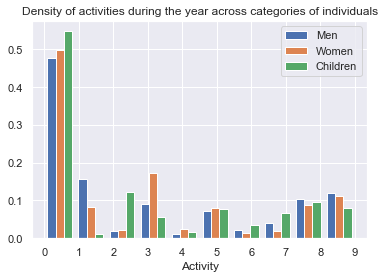

In [51]:
plt.hist([df_men.whatdoing,df_women.whatdoing,df_children.whatdoing],label=["Men","Women","Children"],density=True)
    
plt.title("Density of activities during the year across categories of individuals")
plt.legend(loc='upper right')
plt.xticks([i for i in range(10)])
plt.xlabel("Activity")
plt.show()

In [52]:
# Categories by season

df_winter = df_merged[df_merged.month.isin(winter)]
df_spring = df_merged[df_merged.month.isin(spring)]
df_summer = df_merged[df_merged.month.isin(summer)]
df_fall = df_merged[df_merged.month.isin(fall)]

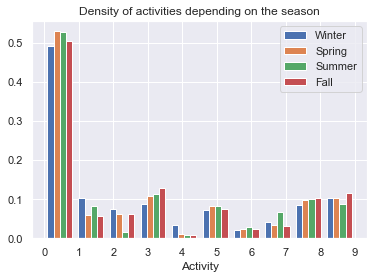

In [53]:
plt.hist([df_winter.whatdoing,df_spring.whatdoing,df_summer.whatdoing,df_fall.whatdoing]
         ,label=["Winter","Spring","Summer","Fall"],density=True)
    
plt.title("Density of activities depending on the season")
plt.legend(loc='upper right')
plt.xticks([i for i in range(10)])
plt.xlabel("Activity")
plt.show()

### VII.2 Model validation

We have created 3 different IMCs: one for men, one for women and one for children. We want to assess the validity of these models by training them on 80% of the data, and comparing the results with the 20% remaining data.

In [54]:
def indiv_sample(df,p):
    #given a dataframe df and a percentage p, returns a dataframe composed of p % of the data built by selecting
    #random individuals, and the complementary dataframe
    nb_ob = 0
    l_indiv = []
    df_copy = df
    while (nb_ob<p*len(df)):
        indiv_rand = sample(list(df_copy.individual.unique()),1)[0]
        nb_ob += len(df[df.individual==indiv_rand])
        l_indiv.append(indiv_rand)
        df_copy = df_copy[~(df_copy.individual==indiv_rand)]
    df_final = df[df.individual.isin(l_indiv)]
    df_comp = df[~(df.individual.isin(l_indiv))]
    df_final.reset_index(inplace=True)
    df_comp.reset_index(inplace=True)
    return({"sample":df_final,"compl":df_comp})

def validation(df_train,df_test,verbose=False):
    #Training the model
    list_P_train = transition(df_train,verbose)
    #Testing the model
    act_test = act_gen(list_P_train,df_test)
    plt.title("Validating the model")
    plt.legend(loc='upper right')
    plt.xticks([i for i in range(10)])
    hist = plt.hist([act_test,df_test.whatdoing],label=["Simulation","Observations"],density=True)
    return(hist)

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.


([array([0.36, 0.16, 0.02, 0.1 , 0.02, 0.14, 0.03, 0.06, 0.11, 0.13]),
  array([0.45, 0.21, 0.  , 0.13, 0.01, 0.08, 0.  , 0.05, 0.09, 0.11])],
 array([0.0, 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9.0],
       dtype=object),
 <a list of 2 Lists of Patches objects>)

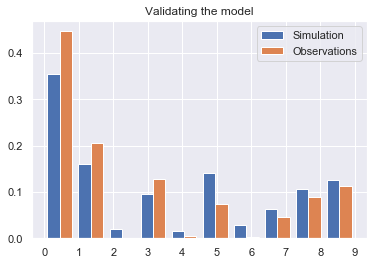

In [55]:
# validation for men
sample_men = indiv_sample(df_men,0.2)
test_men = sample_men["sample"]
train_men = sample_men["compl"]
hist_men = validation(train_men,test_men)
plt.legend(loc='upper right')
hist_men

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.


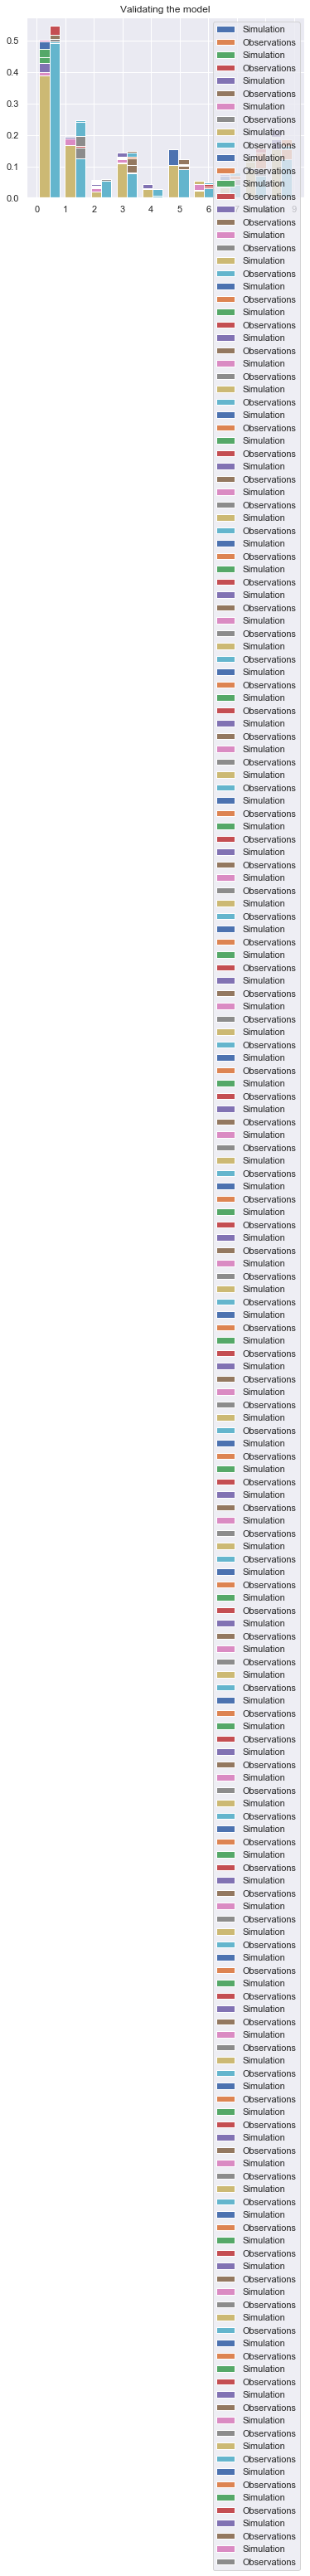

In [56]:
dens_men_sim = np.zeros((100,10))
dens_men_obs = np.zeros((100,10))
for i in range(100):
    sample_men = indiv_sample(df_men,0.2)
    test_men = sample_men["sample"]
    train_men = sample_men["compl"]
    hist_men = validation(train_men,test_men,False)
    for j in range(10):
        dens_men_sim[i][j] = hist_men[0][0][j]
        dens_men_obs[i][j] = hist_men[0][1][j]

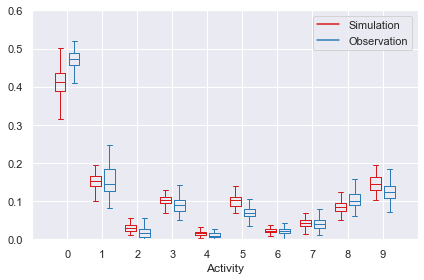

In [57]:
ticks = [str(i) for i in range(10)]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dens_men_sim, positions=np.array(range(np.shape(dens_men_sim)[1]))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dens_men_obs, positions=np.array(range(np.shape(dens_men_obs)[1]))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Simulation')
plt.plot([], c='#2C7BB6', label='Observation')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 0.6)
plt.xlabel("Activity")
plt.tight_layout()

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.


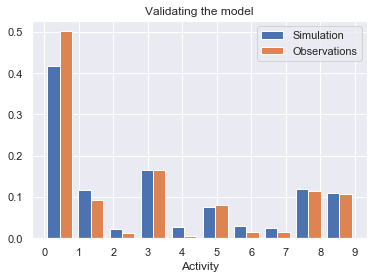

In [58]:
# validation for women
sample_women = indiv_sample(df_women,0.2)
test_women = sample_women["sample"]
train_women = sample_women["compl"]
hist_women = validation(train_women,test_women)

hist_women
plt.legend(loc='upper right')
plt.xlabel("Activity")
plt.show()

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.


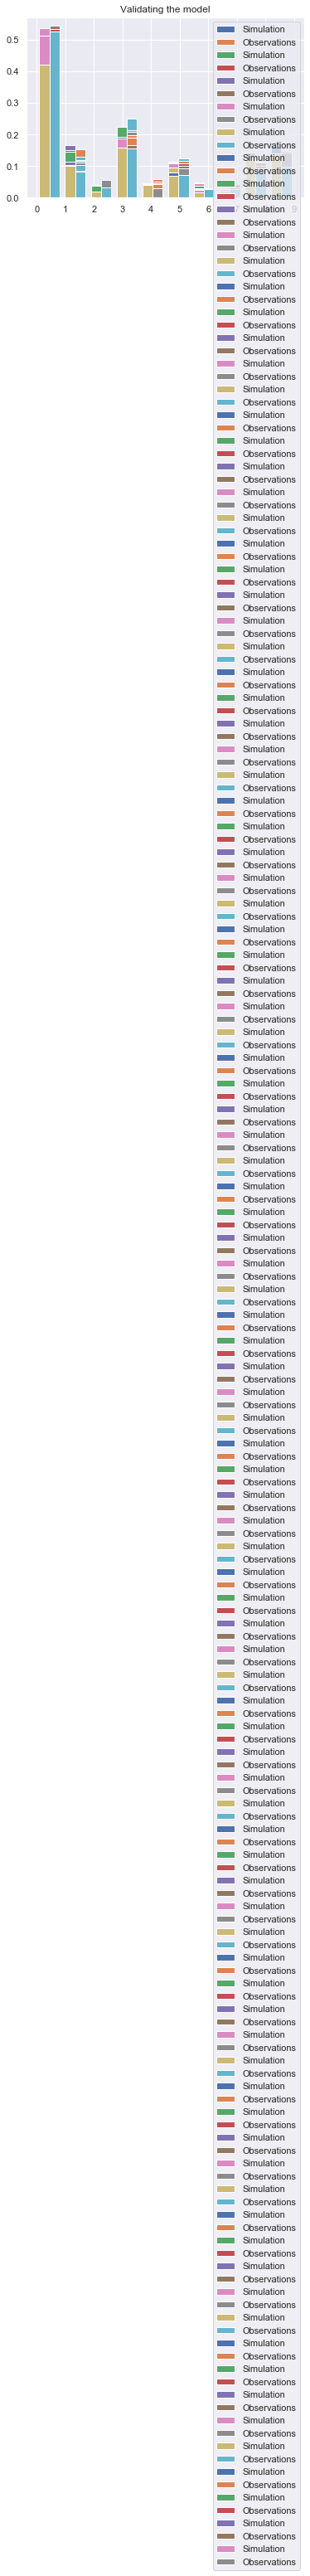

In [59]:
dens_women_sim = np.zeros((100,10))
dens_women_obs = np.zeros((100,10))
for i in range(100):
    sample_women = indiv_sample(df_women,0.2)
    test_women = sample_women["sample"]
    train_women = sample_women["compl"]
    hist_women = validation(train_women,test_women,False)
    for j in range(10):
        dens_women_sim[i][j] = hist_women[0][0][j]
        dens_women_obs[i][j] = hist_women[0][1][j]

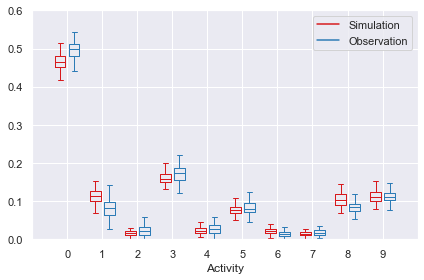

In [60]:
ticks = [str(i) for i in range(10)]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dens_women_sim, positions=np.array(range(np.shape(dens_women_sim)[1]))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dens_women_obs, positions=np.array(range(np.shape(dens_women_obs)[1]))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Simulation')
plt.plot([], c='#2C7BB6', label='Observation')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 0.6)
plt.xlabel("Activity")
plt.tight_layout()

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.


([array([0.49, 0.01, 0.13, 0.08, 0.03, 0.06, 0.02, 0.1 , 0.1 , 0.09]),
  array([0.56, 0.  , 0.11, 0.04, 0.02, 0.11, 0.05, 0.04, 0.09, 0.09])],
 array([0.0, 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9.0],
       dtype=object),
 <a list of 2 Lists of Patches objects>)

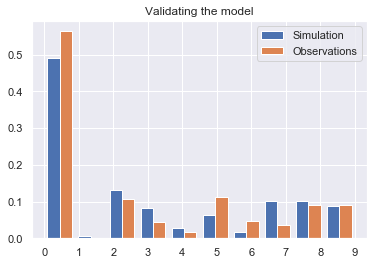

In [61]:
# validation for children
sample_children = indiv_sample(df_children,0.2)
test_children = sample_children["sample"]
train_children = sample_children["compl"]
hist_children = validation(train_children,test_children)

plt.legend(loc='upper right')
hist_children

C:\Users\tangb\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.


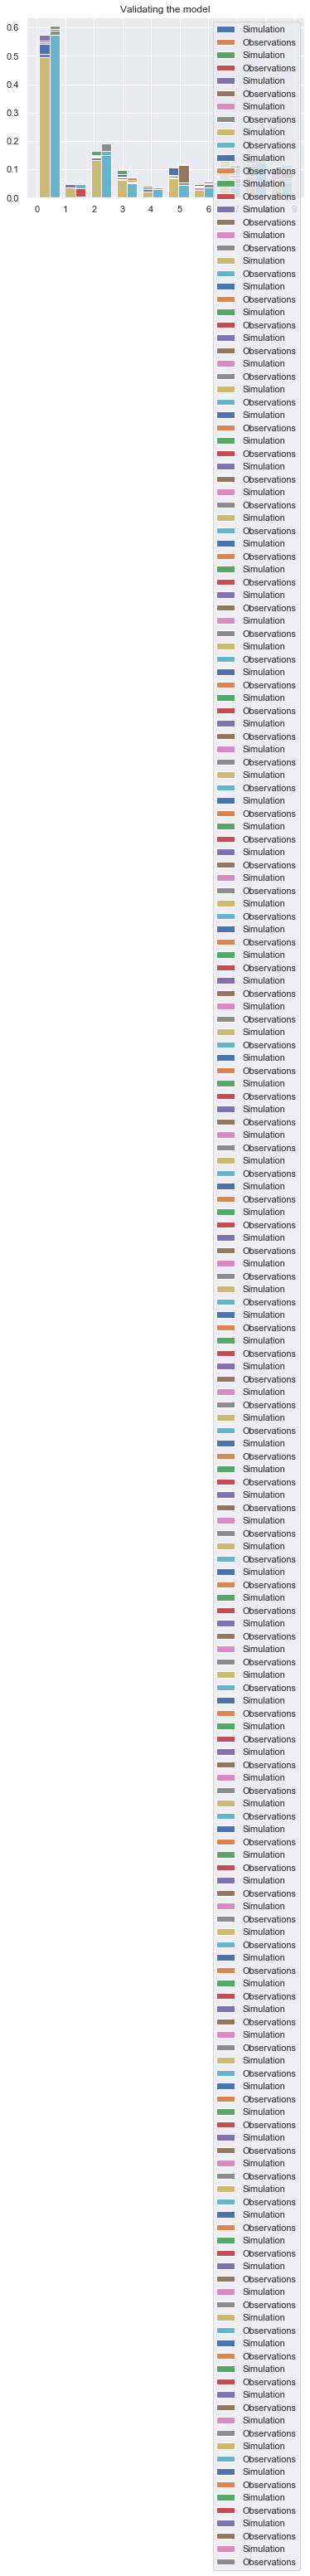

In [62]:
dens_children_sim = np.zeros((100,10))
dens_children_obs = np.zeros((100,10))
for i in range(100):
    sample_children = indiv_sample(df_children,0.2)
    test_children = sample_children["sample"]
    train_children = sample_children["compl"]
    hist_children = validation(train_children,test_children,False)
    for j in range(10):
        dens_children_sim[i][j] = hist_children[0][0][j]
        dens_children_obs[i][j] = hist_children[0][1][j]

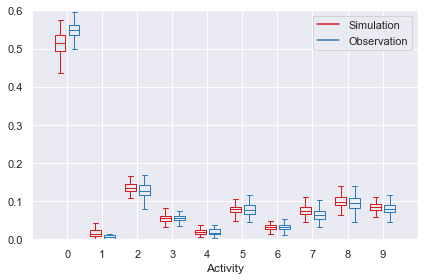

In [63]:
ticks = [str(i) for i in range(10)]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dens_children_sim, positions=np.array(range(np.shape(dens_children_sim)[1]))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dens_children_obs, positions=np.array(range(np.shape(dens_children_obs)[1]))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Simulation')
plt.plot([], c='#2C7BB6', label='Observation')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 0.6)
plt.xlabel("Activity")
plt.tight_layout()